#### MultiLabel Classification with multiple targets... 

Target 1 = q58: Ever had sex<br>
Target 2 = q25: Sad or Hopeless<br>
Target 3 = q45: Ever used Marijuana<br>

In [259]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
%config InlineBackend.figure_format ='retina'

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection 
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score


In [24]:
colors = ['#b166eb', '#8858D4', '#664CC1', '#4B43B2', '#072B8B']
sns.set_palette(colors)


In [25]:
df = pd.read_csv('data/SADCQ.csv')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504249 entries, 0 to 504248
Columns: 151 entries, sitecode to qtransgender
dtypes: float64(142), int64(6), object(3)
memory usage: 580.9+ MB


In [27]:
# Make record # the index

df.set_index('record', inplace=True)

In [202]:
to_drop = ['sitecode', 'sitetype', 'sitetypenum', 'survyear', 'weight',
          'stratum', 'PSU', 'stheight', 'stweight', 'stheight', 
          'stweight', 'bmipct', 'qnobese', 'qnowt', 'q66', 
          'q65', 'sexid', 'sexpart', 'sexpart2', 'q8', 'q9', 
          'q10', 'q11', 'q13', 'q14', 'q16', 'q18', 
          'q19', 'q20', 'q21', 'q22', 'q26', 'q27', 'q28', 
          'q29', 'q31', 'q32', 'q33', 'q34', 'q35', 'q36', 
          'q37', 'q38', 'q39', 'q40', 'q42', 'q43', 'q44', 
          'q46', 'q47', 'q48', 'q49', 'q50', 'q51', 'q52', 
          'q53', 'q54', 'q55', 'q56', 'q57', 'q59', 'q60', 
          'q61', 'q62', 'q63', 'q64', 'q68', 'q69', 'q70', 
          'q71', 'q72', 'q73', 'q74', 'q75', 'q76', 'q81', 
          'q83', 'q84', 'q85', 'q86', 'q89', 
          'qbikehelmet',
 'qdrivemarijuana',
 'qcelldriving',
 'qpropertydamage',
 'qbullyweight',
 'qbullygender',
 'qbullygay',
 'qchokeself',
 'qcigschool',
 'qchewtobschool',
 'qalcoholschool',
 'qtypealcohol2',
 'qhowmarijuana',
 'qmarijuanaschool',
 'qcurrentopioid',
 'qcurrentcocaine',
 'qcurrentheroin',
 'qcurrentmeth',
 'qhallucdrug',
 'qprescription30d',
 'qgenderexp',
 'qtaughtHIV',
 'qtaughtsexed',
 'qtaughtstd',
 'qtaughtcondom',
 'qtaughtbc',
 'qdietpop',
 'qcoffeetea',
 'qsportsdrink',
 'qenergydrink',
 'qsugardrink',
 'qwater',
 'qfastfood',
 'qfoodallergy',
 'qwenthungry',
 'qmusclestrength',
 'qsunscreenuse',
 'qindoortanning',
 'qsunburn',
 'qconcentrating',
 'qcurrentasthma',
 'qwheresleep',
 'qspeakenglish',
 'qtransgender']

In [194]:
df.qbullyweight.value_counts(normalize=True)

2.0    0.741865
1.0    0.258135
Name: qbullyweight, dtype: float64

In [201]:
df.qspeakenglish.isnull().sum()/ len(df)*100

100.0

In [203]:
df.drop(columns=to_drop, inplace=True)

In [204]:
# Just keep 2009 - 2019

df = df[df['year']>=2009]

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296030 entries, 3961 to 2226523
Data columns (total 27 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   sitename  296030 non-null  object 
 1   year      296030 non-null  int64  
 2   age       295009 non-null  float64
 3   sex       293575 non-null  float64
 4   grade     291733 non-null  float64
 5   race4     284810 non-null  float64
 6   race7     284810 non-null  float64
 7   bmi       266288 non-null  float64
 8   sexid2    239957 non-null  float64
 9   q12       275188 non-null  float64
 10  q15       285562 non-null  float64
 11  q17       279400 non-null  float64
 12  q23       286648 non-null  float64
 13  q24       237421 non-null  float64
 14  q25       288586 non-null  float64
 15  q30       239885 non-null  float64
 16  q41       259328 non-null  float64
 17  q45       169528 non-null  float64
 18  q58       235980 non-null  float64
 19  q67       215616 non-null  float64
 20  

In [206]:
df_full = df.dropna(subset=['q58', 'q25', 'q45'])

In [207]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146277 entries, 7354 to 2226523
Data columns (total 27 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   sitename  146277 non-null  object 
 1   year      146277 non-null  int64  
 2   age       146012 non-null  float64
 3   sex       145755 non-null  float64
 4   grade     144816 non-null  float64
 5   race4     142796 non-null  float64
 6   race7     142796 non-null  float64
 7   bmi       135006 non-null  float64
 8   sexid2    108574 non-null  float64
 9   q12       135959 non-null  float64
 10  q15       139871 non-null  float64
 11  q17       137572 non-null  float64
 12  q23       142486 non-null  float64
 13  q24       102303 non-null  float64
 14  q25       146277 non-null  float64
 15  q30       118636 non-null  float64
 16  q41       134357 non-null  float64
 17  q45       146277 non-null  float64
 18  q58       146277 non-null  float64
 19  q67       138454 non-null  float64
 20  

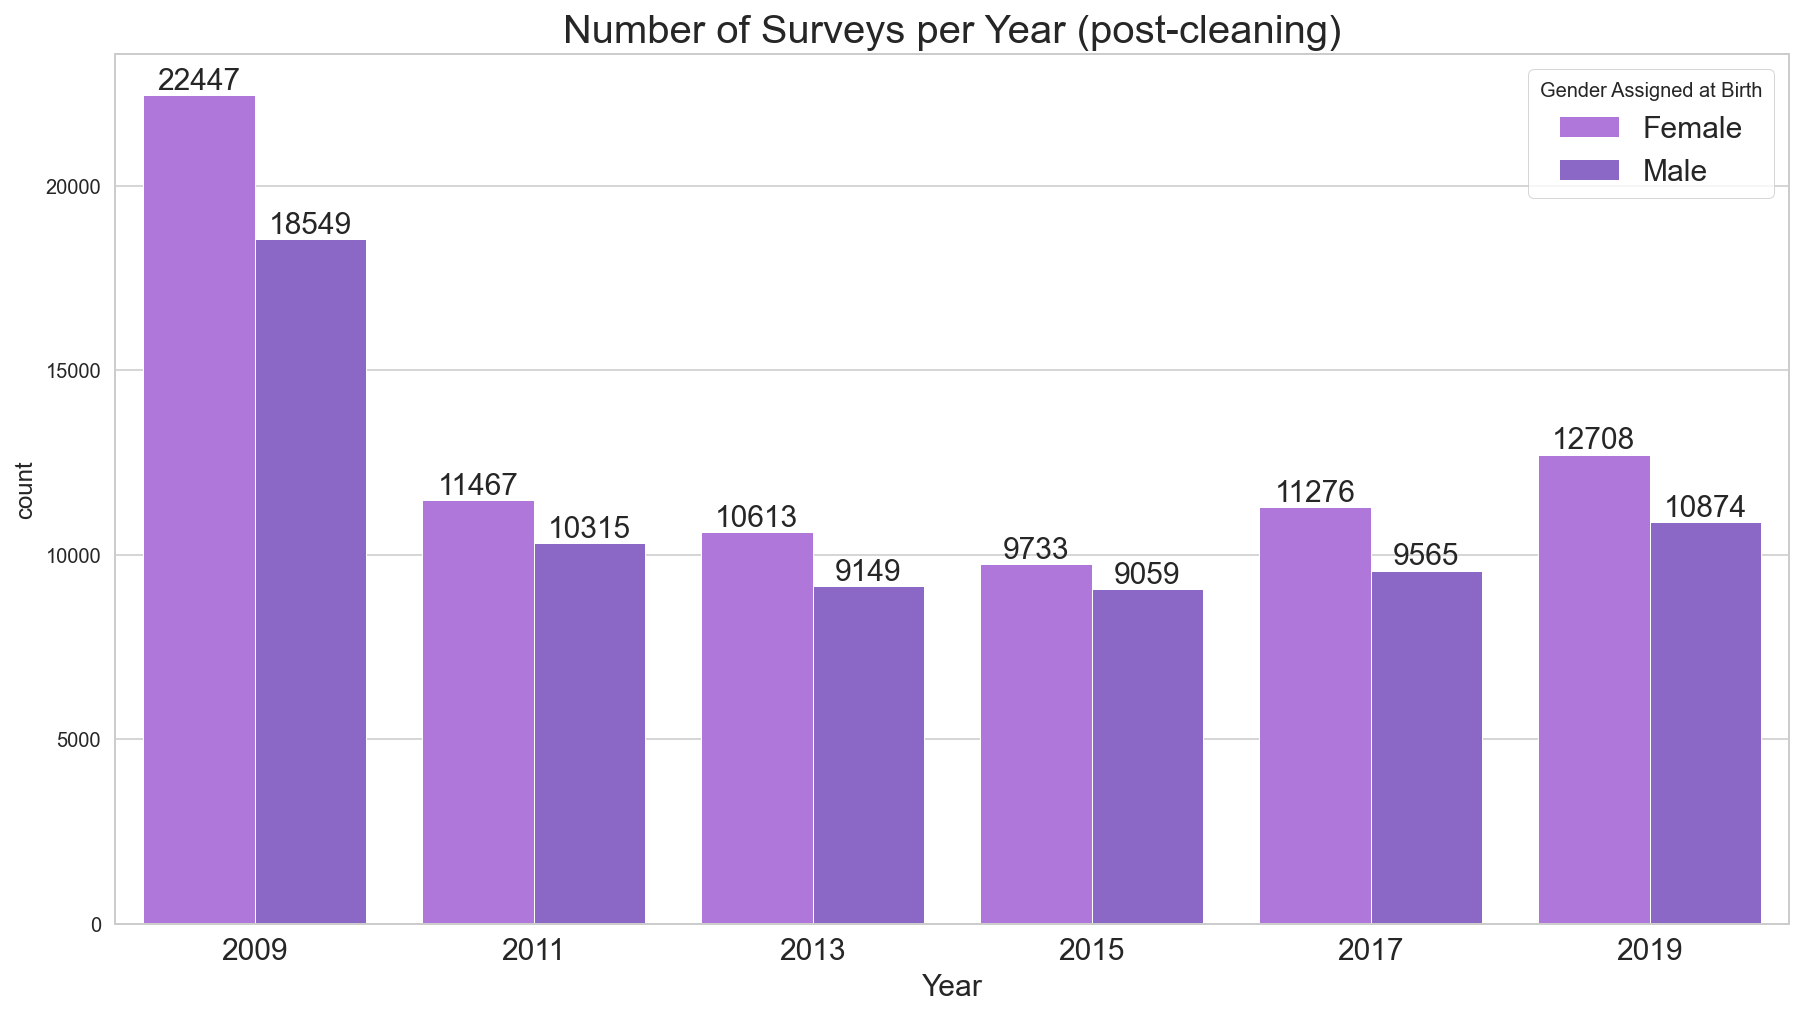

In [210]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(data=df_full, x='year', hue='sex', palette=colors, ax=ax)

ax.bar_label(ax.containers[0], fontsize=15, fmt='%d')
ax.bar_label(ax.containers[1], fontsize=15, fmt='%d')

ax.set_title('Number of Surveys per Year (post-cleaning)', fontsize=20)
ax.set_xticklabels(labels=[2009, 2011, 2013, 2015, 2017, 2019], fontsize=15)
ax.set_xlabel('Year', fontsize=15)
ax.legend(title='Gender Assigned at Birth', labels=['Female', 'Male'], loc='upper right', fontsize=15);


In [211]:
age_dict = {1: '12 yrs -', 2: '13 yrs', 3: '14 yrs', 
           4: '15 yrs', 5: '16 yrs', 6: '17 yrs', 7: '18 yrs +'}
age_labels = [v for k, v in age_dict.items()]

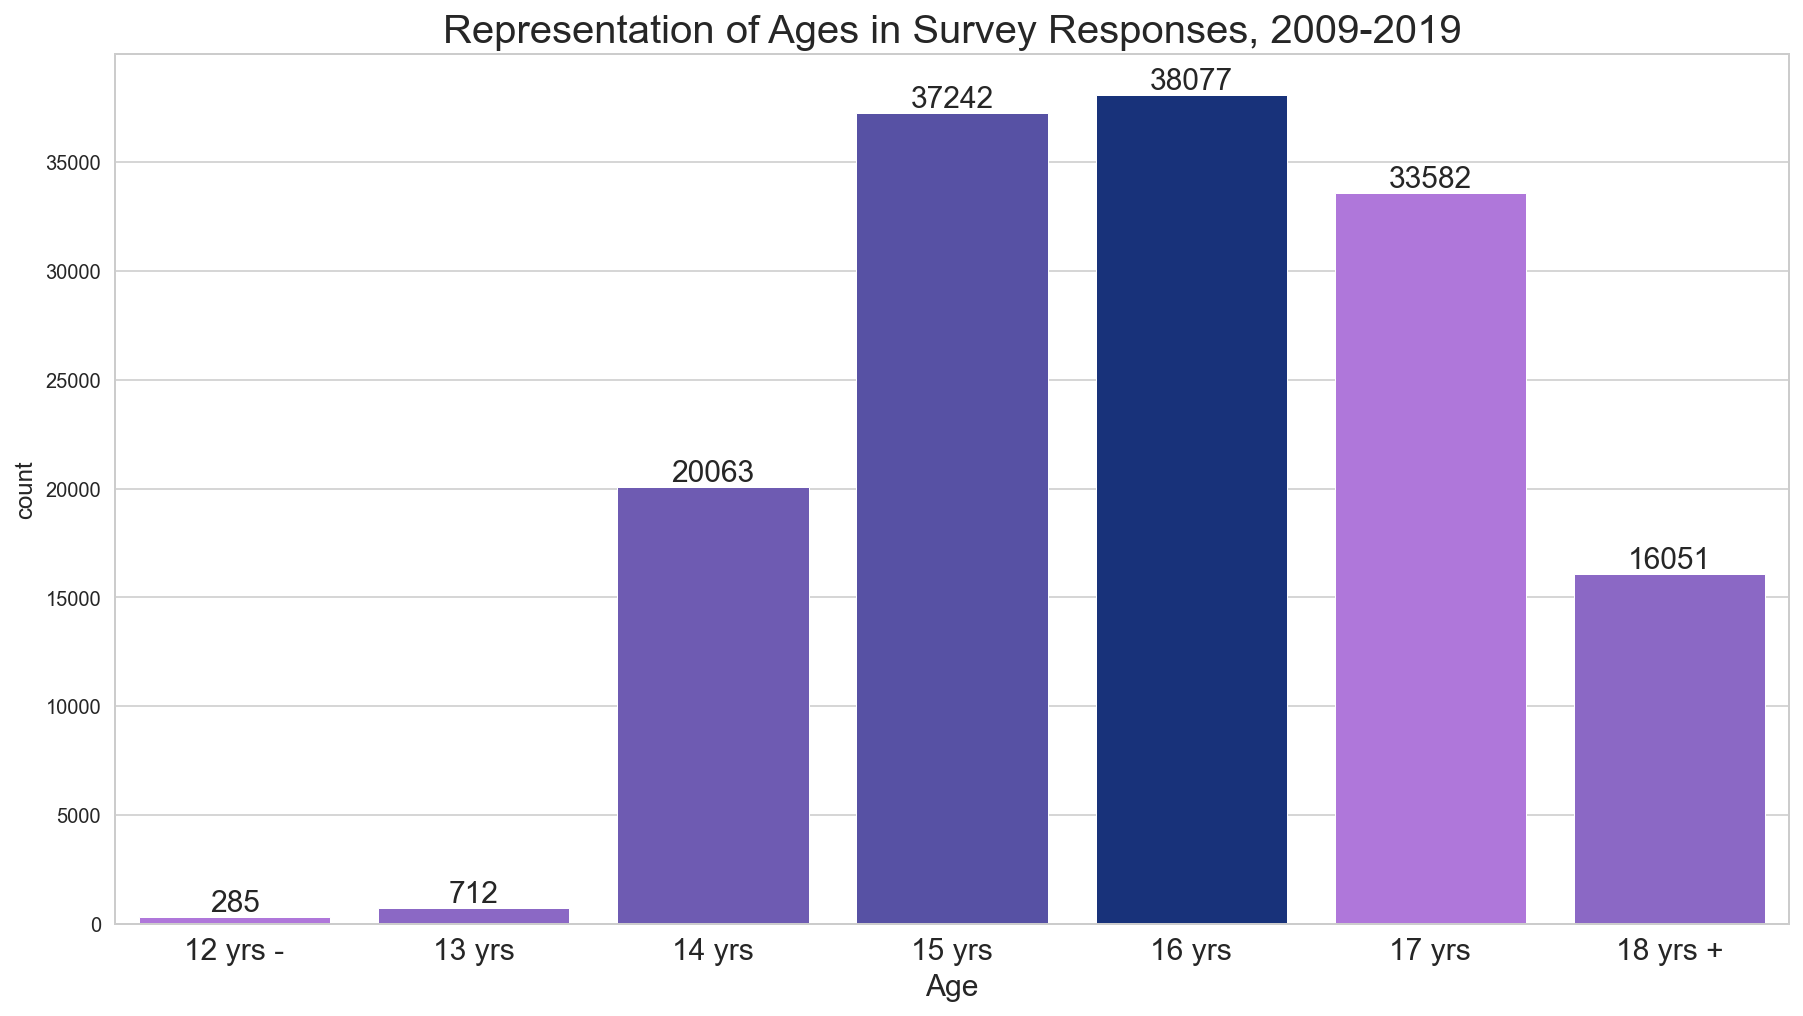

In [212]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(data=df_full, x='age', palette=colors, ax=ax)
ax.set_xticklabels(labels=age_labels, fontsize=15)
ax.set_title('Representation of Ages in Survey Responses, 2009-2019', fontsize=20)
ax.bar_label(ax.containers[0], fontsize=15, fmt='%d')
ax.set_xlabel('Age', fontsize=15);

In [213]:
race7_dict = {1: 'AmInd/AlaskaNat', 2: 'Asian', 3: 'Black or Af Am', 
             4: 'Hisp/Latinx', 5: 'NatHaw/OtherPacIsl', 6: 'White', 7: 'Multiple Races (Non-Hisp)'}
race7_labels = ['Hisp/Latinx', 'Black or Af Am', 
               'White', 'Asian', 'Multiple Races', 
               'NatHaw/OtherPacIsl', 'AmInd/AlaskaNat']

In [215]:
df_full.race7.value_counts(), df_full.race4.value_counts()

(4.0    57656
 3.0    33689
 6.0    27526
 2.0    14837
 7.0     6551
 5.0     1518
 1.0     1019
 Name: race7, dtype: int64,
 3.0    57656
 2.0    33689
 1.0    27526
 4.0    23925
 Name: race4, dtype: int64)

In [216]:
df_full.race7.isnull().sum(), df_full.race4.isnull().sum()

(3481, 3481)

In [217]:
# drop race4
df_full.drop(columns='race4', inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


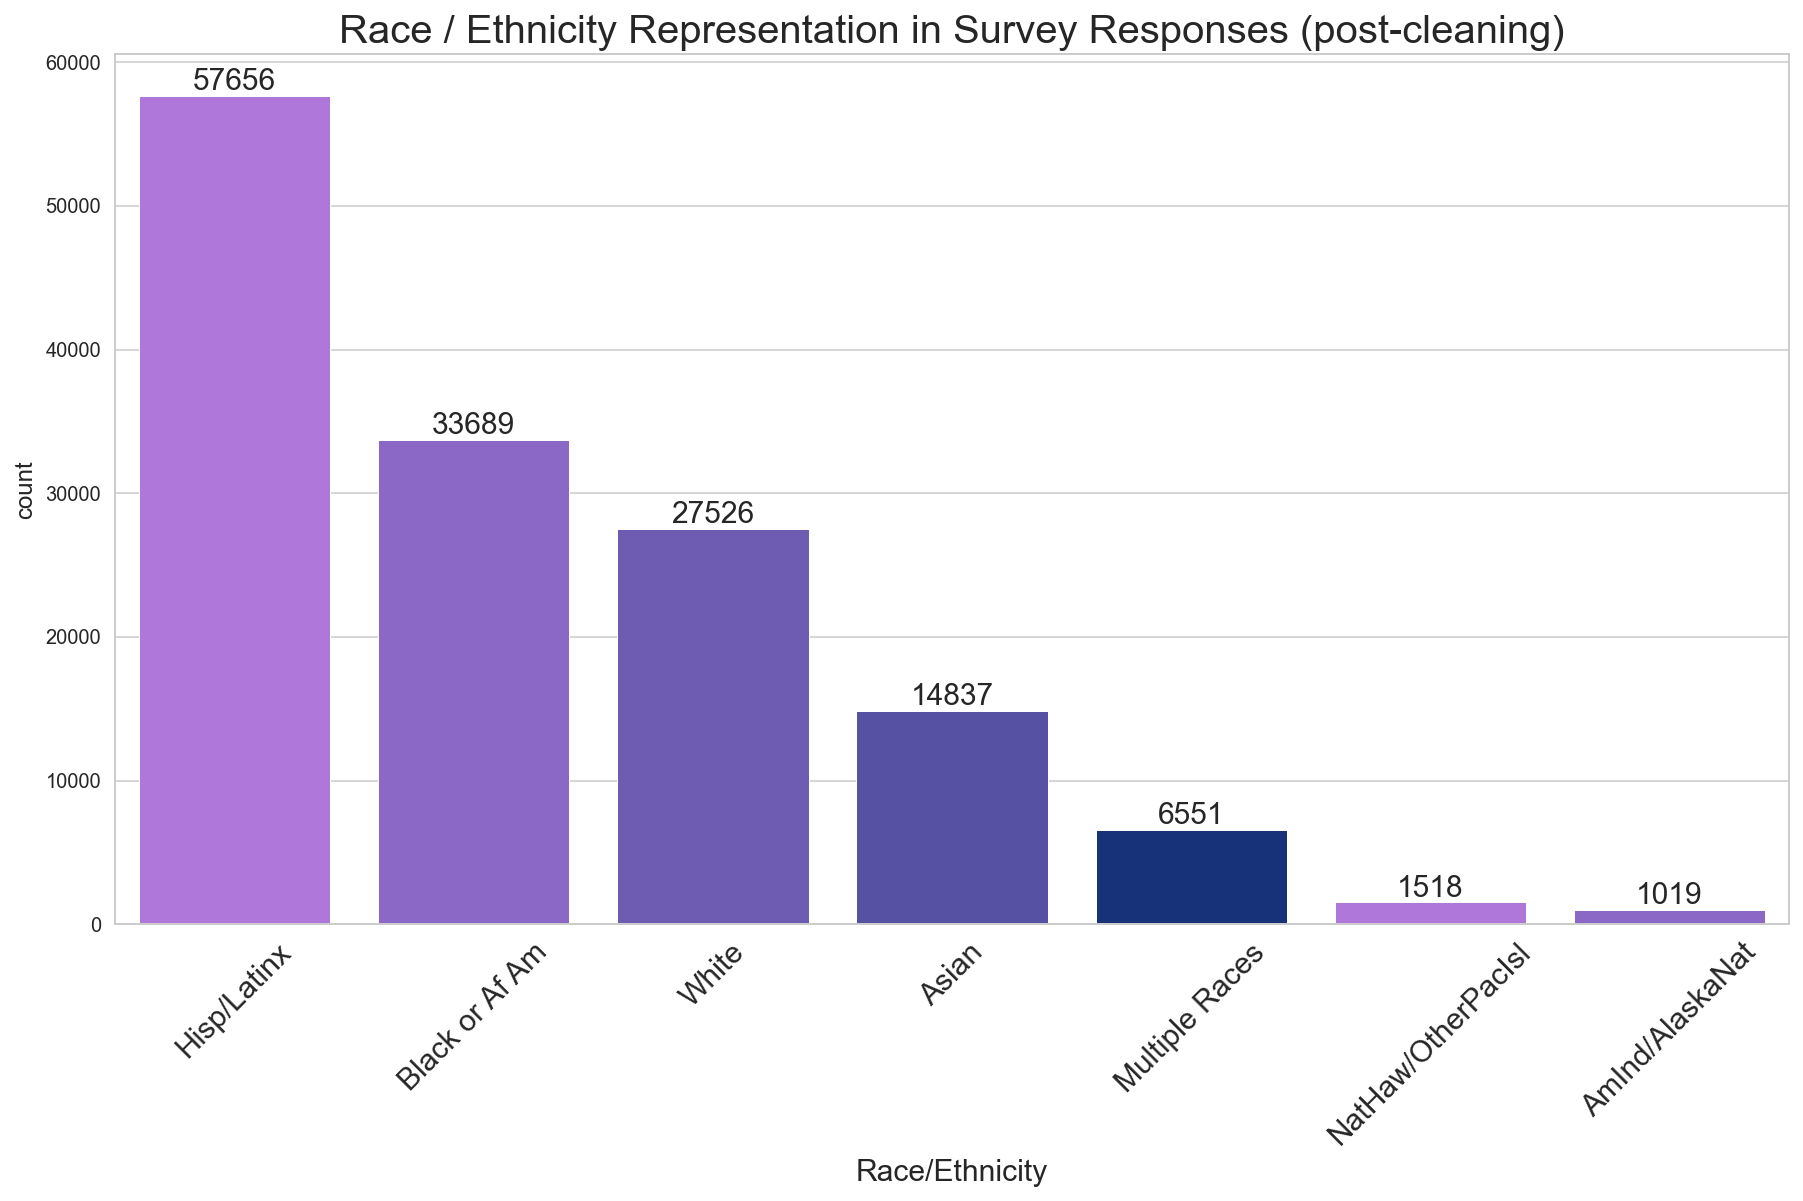

In [219]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(data=df_full, x='race7', palette=colors, ax=ax, 
             order=df.race7.value_counts().index)
ax.set_xticklabels(labels=race7_labels, rotation=45, fontsize=15)
ax.set_title('Race / Ethnicity Representation in Survey Responses (post-cleaning)', fontsize=20)
ax.bar_label(ax.containers[0], fontsize=15, fmt='%d')
ax.set_xlabel('Race/Ethnicity', fontsize=15);

In [36]:
grade_labels = ['9th', '10th', '11th', '12th']

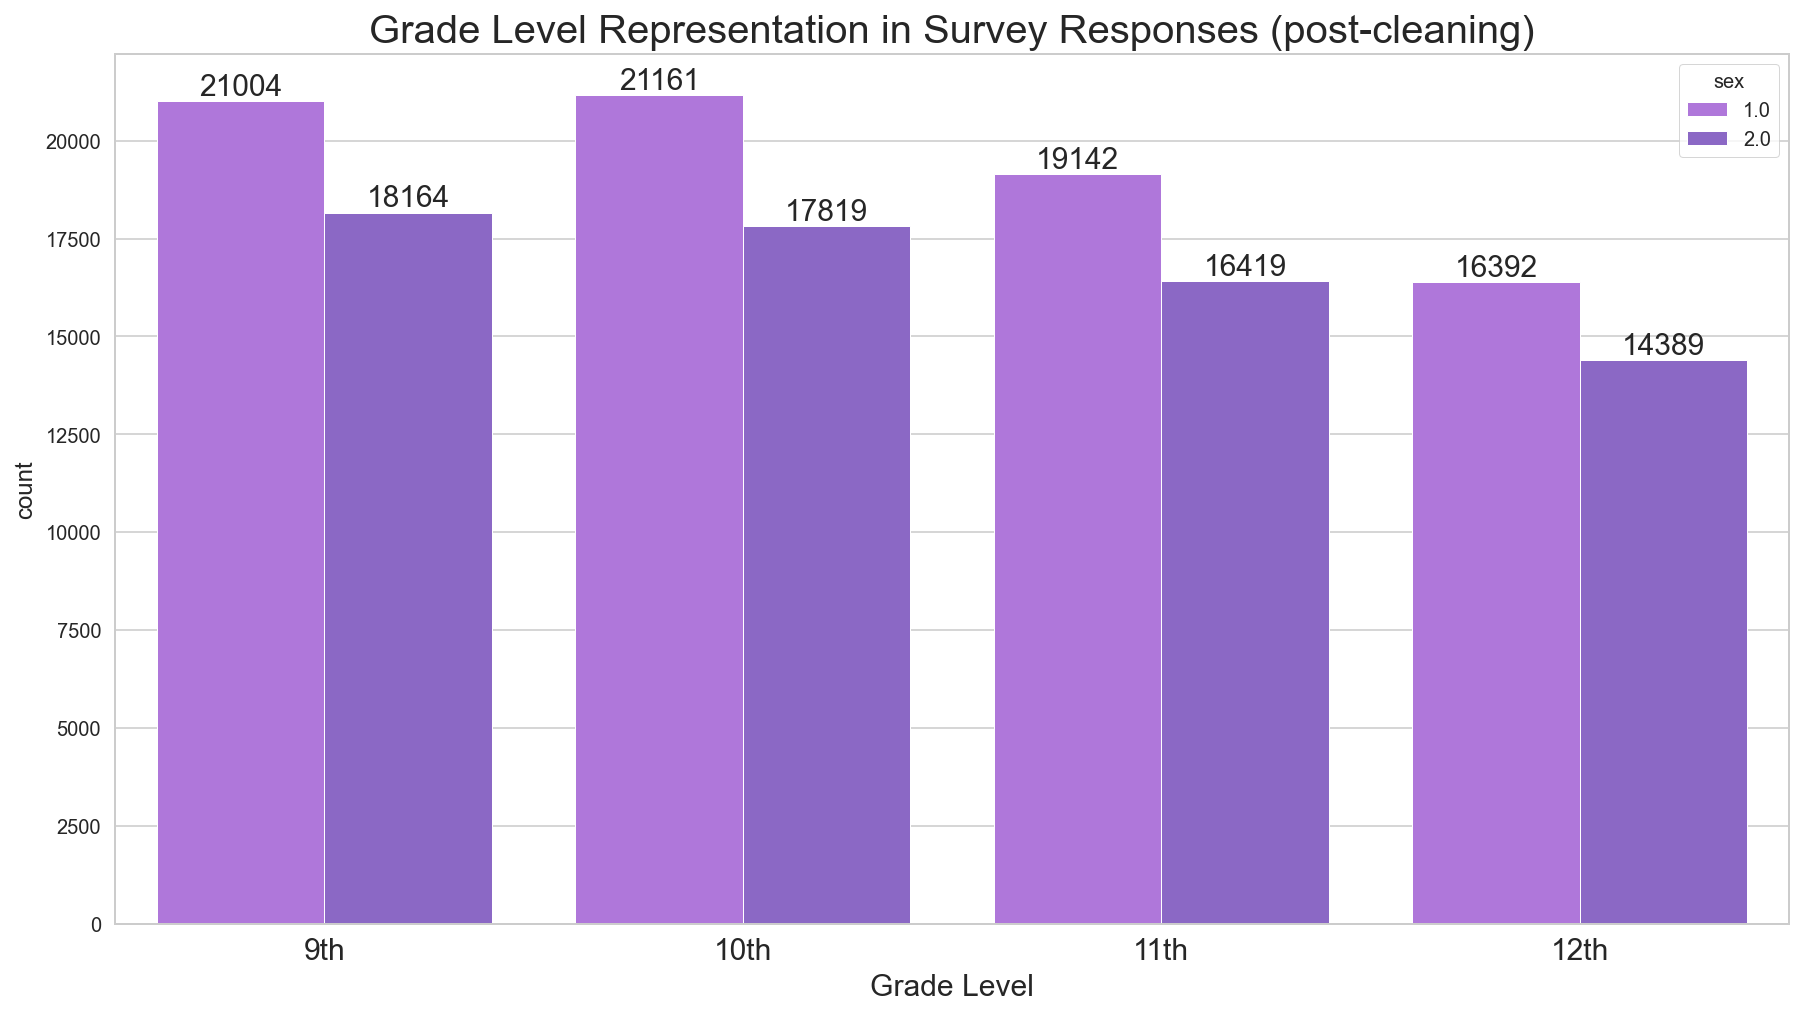

In [220]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(data=df_full, x='grade', hue='sex', palette=colors, ax=ax)
ax.set_xticklabels(labels=grade_labels, fontsize=15)
ax.set_title('Grade Level Representation in Survey Responses (post-cleaning)', fontsize=20)
ax.bar_label(ax.containers[0], fontsize=15, fmt='%d')
ax.bar_label(ax.containers[1], fontsize=15, fmt='%d')

ax.set_xlabel('Grade Level', fontsize=15);

In [221]:
sex_dict = {1: 'Female', 2: 'Male'}
grade_dict = {1: '9th Grade', 2: '10th Grade', 3: '11th Grade', 
             4: '12th Grade'}

In [222]:
df_full.q58.unique()

array([0., 1.])

In [223]:
df_full.q25.unique()

array([0., 1.])

In [224]:
df_full.q45.unique()

array([0., 1.])

In [45]:
# For each target, replace 2's (No's...) with 0s so that 1 (Yes) is the positive class

df_full.q58.replace(to_replace={2.: 0}, inplace=True)
df_full.q25.replace(to_replace={2.: 0}, inplace=True)
df_full.q45.replace(to_replace={1.: 0, 2.: 1, 3.: 1, 4.: 1, 5.: 1, 6.: 1, 7.: 1}, inplace=True)

In [225]:
df_full.isnull().sum()

sitename        0
year            0
age           265
sex           522
grade        1461
race7        3481
bmi         11271
sexid2      37703
q12         10318
q15          6406
q17          8705
q23          3791
q24         43974
q25             0
q30         27641
q41         11920
q45             0
q58             0
q67          7823
q77         67590
q78          9512
q79         12489
q80         12385
q82         32408
q87         15690
q88         76877
dtype: int64

In [274]:
df_full.drop(columns=['sitename', 'year'], inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [275]:
df_full.to_csv('data/df_full.csv')

In [276]:
from skmultilearn.model_selection import IterativeStratification


In [277]:
X = df_full.drop(columns=['q58', 'q25', 'q45'])

In [278]:
y = df_full[['q58', 'q25', 'q45']]
y.shape

(146277, 3)

In [279]:
X.shape, y.shape

((146277, 21), (146277, 3))

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [281]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((117021, 21), (29256, 21), (117021, 3), (29256, 3))

In [282]:
y_train.head()

,q58,q25,q45
record,,,
1240359,0.0,1.0,0.0
2161318,0.0,0.0,0.0
205522,0.0,0.0,0.0
1143443,0.0,0.0,0.0
1815464,0.0,1.0,0.0


In [283]:
y_test.q58.sum() / len(y_test) * 100

39.8687448728466

In [284]:
y_test.q25.sum() / len(y_test) * 100

29.734071643423572

In [285]:
y_test.q45.sum() / len(y_test) * 100

36.040470330872296

In [286]:
# Impute missing values in train set

In [287]:
from sklearn.impute import KNNImputer

In [288]:
imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')

In [289]:
imputer.fit(X_train)

KNNImputer(weights='distance')

In [309]:
imputer2 = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')

In [310]:
imputer2.fit(X_test)

KNNImputer(weights='distance')

In [311]:
X_test_trans = imputer.transform(X_test)

In [290]:
X_train_trans = imputer.transform(X_train)

In [312]:
X_test_trans.shape

(29256, 21)

In [294]:
X_train_trans.shape

(117021, 21)

In [313]:
X_test_trans = pd.DataFrame(data=X_test_trans, index=X_test.index, columns=X_test.columns)

In [296]:
X_train_trans = pd.DataFrame(data=X_train_trans, index=X_train.index, columns=X_train.columns)

In [297]:
X_train_trans

,age,sex,grade,race7,bmi,sexid2,q12,q15,q17,q23,...,q30,q41,q67,q77,q78,q79,q80,q82,q87,q88
record,,,,,,,,,,,,,,,,,,,,,
1240359,3.0,1.0,1.0,6.0,17.935469,1.0,1.0,1.0,1.000000,2.0,...,2.0,1.0,3.0,5.0,5.0,3.0,5.000000,1.000000,2.0,1.0
2161318,7.0,1.0,4.0,3.0,22.494016,1.0,1.0,1.0,1.000000,2.0,...,2.0,1.0,3.0,1.0,5.0,7.0,7.000000,2.000000,2.0,2.0
205522,4.0,2.0,1.0,6.0,27.299383,1.0,1.0,2.0,1.000000,2.0,...,2.0,1.0,3.0,8.0,8.0,2.0,3.000000,4.000000,2.0,4.0
1143443,3.0,1.0,1.0,4.0,22.148422,1.0,1.0,1.0,1.000000,2.0,...,2.0,1.0,3.0,8.0,1.0,1.0,3.000000,1.000000,2.0,3.0
1815464,5.0,1.0,2.4,3.0,21.161087,1.0,1.0,1.0,1.000000,2.0,...,2.0,1.0,3.0,7.0,2.0,1.0,5.000000,2.000000,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401846,4.0,1.0,1.0,4.0,21.216880,1.0,1.0,1.0,3.620591,2.0,...,1.0,3.0,4.0,5.0,5.0,4.0,7.000000,1.000000,2.0,2.0
911622,6.0,2.0,4.0,2.0,25.770090,1.0,1.0,1.0,1.000000,2.0,...,2.0,1.0,4.0,8.0,7.0,1.0,4.857376,1.000000,2.0,2.0
1301387,4.0,1.0,2.0,3.0,24.563842,1.0,1.0,1.0,1.000000,2.0,...,2.0,1.0,3.0,3.0,1.0,6.0,5.000000,1.000000,2.0,6.0


In [299]:
y_train.shape

(117021, 3)

In [298]:
X_train_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117021 entries, 1240359 to 1517467
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   age     117021 non-null  float64
 1   sex     117021 non-null  float64
 2   grade   117021 non-null  float64
 3   race7   117021 non-null  float64
 4   bmi     117021 non-null  float64
 5   sexid2  117021 non-null  float64
 6   q12     117021 non-null  float64
 7   q15     117021 non-null  float64
 8   q17     117021 non-null  float64
 9   q23     117021 non-null  float64
 10  q24     117021 non-null  float64
 11  q30     117021 non-null  float64
 12  q41     117021 non-null  float64
 13  q67     117021 non-null  float64
 14  q77     117021 non-null  float64
 15  q78     117021 non-null  float64
 16  q79     117021 non-null  float64
 17  q80     117021 non-null  float64
 18  q82     117021 non-null  float64
 19  q87     117021 non-null  float64
 20  q88     117021 non-null  float64
dtypes: 

In [303]:
y.q45.value_counts(normalize=True)

0.0    0.638173
1.0    0.361827
Name: q45, dtype: float64

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'Proportion of Classes for each Target')

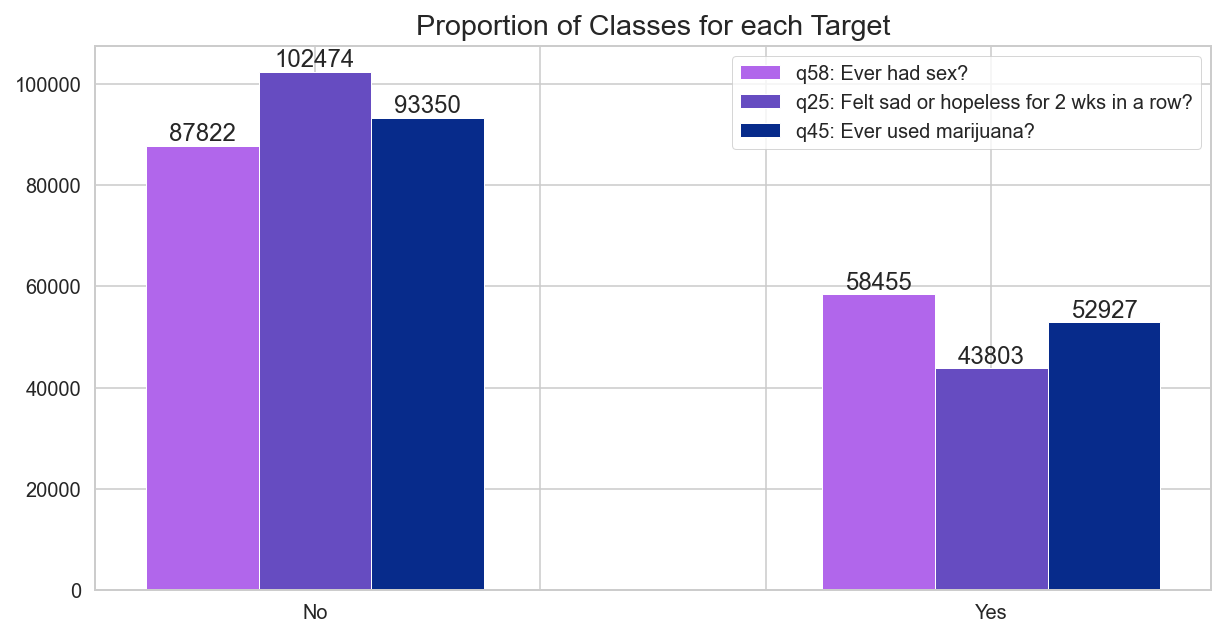

In [300]:
fig, ax = plt.subplots(figsize=(10, 5))

d_heights, d_bins = np.histogram(y['q58'],bins=[0, .3, 1])
m_heights, m_bins = np.histogram(y['q25'], bins=d_bins)
s_heights, s_bins = np.histogram(y['q45'], bins=m_bins)



width = (d_bins[1] - d_bins[0])/6.0

ax.bar(d_bins[:-1]+width, d_heights, width=width, facecolor=colors[0], label='q58: Ever had sex?')
ax.bar(m_bins[:-1]+width*2, m_heights, width=width, facecolor=colors[2], label = 'q25: Felt sad or hopeless for 2 wks in a row?')
ax.bar(s_bins[:-1]+width*3, s_heights, width=width, facecolor=colors[4], label='q45: Ever used marijuana?')

ax.bar_label(ax.containers[0], fontsize=12, fmt='%d')
ax.bar_label(ax.containers[1], fontsize=12, fmt='%d')
ax.bar_label(ax.containers[2], fontsize=12, fmt='%d')

ax.set_xticklabels(labels=['', 'No', '', '','Yes'])

ax.legend()
ax.set_title('Proportion of Classes for each Target')

In [129]:
df.q45.value_counts(normalize=True)

0.0    0.631848
1.0    0.368152
Name: q45, dtype: float64

In [304]:
rf = RandomForestClassifier(random_state=42)

In [307]:
rf.fit(X_train_trans, y_train)

RandomForestClassifier(random_state=42)

In [314]:
preds = rf.predict(X_test_trans)

In [345]:
pred_probs = rf.predict_proba(X_test_trans)

In [352]:
q58_probs = pred_probs[0]
q25_probs = pred_probs[1]
q45_probs = pred_probs[2]

In [342]:
print("Accuracy for Q58:", accuracy_score(y_test.iloc[:, 0], preds[:, 0]))
print("Precision for Q58:", precision_score(y_test.iloc[:, 0], preds[:, 0]))
print("Recall for Q58:", recall_score(y_test.iloc[:, 0], preds[:, 0]))
print("F1 for Q58:", f1_score(y_test.iloc[:, 0], preds[:, 0]))


Accuracy for Q58: 0.7649712879409352
Precision for Q58: 0.7308137292711145
Recall for Q58: 0.6498628257887518
F1 for Q58: 0.687965147939735


In [343]:
print("Accuracy for Q25:", accuracy_score(y_test.iloc[:, 1], preds[:, 1]))
print("Precision for Q25:", precision_score(y_test.iloc[:, 1], preds[:, 1]))
print("Recall for Q25:", recall_score(y_test.iloc[:, 1], preds[:, 1]))
print("F1 for Q25:", f1_score(y_test.iloc[:, 1], preds[:, 1]))


Accuracy for Q25: 0.7621684440798469
Precision for Q25: 0.6920361791308185
Recall for Q25: 0.3606161627773307
F1 for Q25: 0.47415356711003626


In [344]:
print("Accuracy for Q45:", accuracy_score(y_test.iloc[:, 2], preds[:, 2]))
print("Precision for Q45:", precision_score(y_test.iloc[:, 2], preds[:, 2]))
print("Recall for Q45:", recall_score(y_test.iloc[:, 2], preds[:, 2]))
print("F1 for Q45:", f1_score(y_test.iloc[:, 2], preds[:, 2]))


Accuracy for Q45: 0.7928288214383374
Precision for Q45: 0.7483106236845021
Recall for Q45: 0.6406487101669196
F1 for Q45: 0.690307087016504


In [354]:
y_test.iloc[200], q58_probs[200]

(q58    0.0
 q25    0.0
 q45    0.0
 Name: 1156902, dtype: float64,
 array([0.99, 0.01]))

In [328]:
from sklearn.metrics import multilabel_confusion_matrix

In [334]:
cf = multilabel_confusion_matrix(y_test, preds)
cf

array([[[14800,  2792],
        [ 4084,  7580]],

       [[19161,  1396],
        [ 5562,  3137]],

       [[16440,  2272],
        [ 3789,  6755]]])

In [ ]:
def run_experiments(X_train: pd.DataFrame, y_train: pd.DataFrame, 
                   X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame: 
    dfs = []
    models = [
        ('LogReg', LogisticRegression()),
        ('RF', RandomForestClassifier()), 
        ('KNN', KNeighborsClassifier()), 
        ('SVM', SVC()), 
        ('GNB', GaussianNB()), 
        ('XGB', XGBClassifier())
    ]
    results = []
    names = []
    scoring = ['accuracy', 'precision', 'recall', 
               'f1', 'roc_auc']
    target_names = ['Negative', 'Positive']
    for name, model in models: 
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, 
                                   target_names = target_names))
        results.append(cv_results)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
    
    final = pd.concat(dfs, ignore_index=True)
    return final